Import necessary stuff along with setting flags. For the MP1 most flags are set to 1, displaying basically all milestones.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import statistics
#from memory_profiler import memory_usage #wont work for some reason, and I dont wanna waste any more time on it
import numba
from numba import jit, njit, prange
import cProfile, pstats
try:
    profile
except NameError:
    def profile(func):
        return func
testMemory = 1
gridSizes = [64,128,256,512,1024,2048,4096]
sizeComparison = 1
regions = {"Full": (-2, 1.5, -2, 2),"Seahorse Valley": (-0.8, -0.7, 0.05, 0.15),"Elephant Valley": (0.25, 0.35, -0.05, 0.05),"Deep Seahorse": (-0.7435, -0.7425, 0.1315, 0.1325)}
regionTest = 1
cProfiling = 1
makePlots = 1
gridPlot = 1

The various mandelbrot functions:

In [2]:
#@profile
def mandelBrot(xMin, xMax, yMin, yMax, xyValues,dataType):
    xDomain, yDomain = np.linspace(xMin,xMax,xyValues).astype(dataType), np.linspace(yMin,yMax,xyValues).astype(dataType)
    bound = 2
    power = 2            # any positive floating point value (n)
    maxIterations = 50   # any positive integer value
    iterationArray = []

    for y in yDomain:
        row = []
        for x in xDomain:
            c = complex(x,y)
            z = 0
            for iterationNumber in range(maxIterations):
                if(abs(z) >= bound):
                    row.append(iterationNumber)
                    break
                else: z = z**power + c
            else:
                row.append(0)
        iterationArray.append(row)
    return np.array(iterationArray)

#@profile
def mandelBrotFast(xMin, xMax, yMin, yMax, xyValues,dataType):
    xDomain, yDomain = np.linspace(xMin,xMax,xyValues).astype(dataType), np.linspace(yMin,yMax,xyValues).astype(dataType)
    bound = 2
    power = 2            # any positive floating point value (n)
    maxIterations = 50   # any positive integer value
    X, Y = np.meshgrid(xDomain,yDomain)
    C = X + 1j*Y
    #print(f"Shape: {C.shape}")
    #print(f"Type: {C.dtype}")
    # Z starts at 0 everywhere, M counts iterations
    Z = np.zeros_like(C, dtype=np.complex128)
    M = np.zeros(C.shape, dtype=np.int32)

    # Mandelbrot iterations (only loop we keep)
    for _ in range(maxIterations):
        mask = np.abs(Z) <= bound  # points not escaped yet
        # Update Z only where not escaped
        Z[mask] = Z[mask]**power + C[mask]
        # Count iterations only where not escaped
        M[mask] += 1
    M[M == maxIterations] = 0
    return M

@njit
def mandelBrotNumba(xMin, xMax, yMin, yMax, xyValues, dataType):
    bound = 2.0
    bound2 = bound * bound
    maxIterations = 50
    result = np.zeros((xyValues, xyValues), dtype=np.int32)

    for i in range(xyValues):
        y = yMin + (yMax - yMin) * i / (xyValues - 1)
        for j in range(xyValues):
            x = xMin + (xMax - xMin) * j / (xyValues - 1)
            zr = 0.0
            zi = 0.0
            for iterationNumber in range(maxIterations):
                if zr*zr + zi*zi >= bound2:
                    result[i, j] = iterationNumber
                    break
                # z = z^2 + c (manual complex arithmetic)
                temp = zr*zr - zi*zi + x
                zi = 2.0*zr*zi + y
                zr = temp
    return result

@njit(parallel=True)
def mandelBrotNumbaParallel(xMin, xMax, yMin, yMax, xyValues, dataType):
    bound = 2.0
    bound2 = bound * bound
    maxIterations = 50
    result = np.zeros((xyValues, xyValues), dtype=np.int32)

    for i in prange(xyValues):   # <- only change (parallel loop)
        y = yMin + (yMax - yMin) * i / (xyValues - 1)

        for j in range(xyValues):
            x = xMin + (xMax - xMin) * j / (xyValues - 1)
            zr = 0.0
            zi = 0.0
            for iterationNumber in range(maxIterations):
                if zr*zr + zi*zi >= bound2:
                    result[i, j] = iterationNumber
                    break
                # z = z^2 + c (manual complex arithmetic)
                temp = zr*zr - zi*zi + x
                zi = 2.0 * zr * zi + y
                zr = temp

    return result


Benchmarking and plotting functions:

In [3]:
def benchmark(func, *args, nRuns=10):
    times = []

    for _ in range (nRuns):
        startTime = time.perf_counter()
        result = func(*args)
        times.append(time.perf_counter()-startTime)
    
    medianTime = statistics.median(times)
    print(f"Median: {medianTime:.4f}s, Mean: {statistics.mean(times):.4f}, Min: {min(times):.4f}, Max: {max(times):.4f}")
    return medianTime, result

def plotMandelbrot(result, xMin, xMax, yMin, yMax,title="Mandelbrot", ax=None):
    xDomain = np.linspace(xMin, xMax, result.shape[1])
    yDomain = np.linspace(yMin, yMax, result.shape[0])

    if ax is None:
        fig, ax = plt.subplots()
    
    mesh = ax.pcolormesh(xDomain, yDomain, result,cmap="magma", shading="auto")
    ax.set_xlabel("Real-Axis")
    ax.set_ylabel("Imaginary-Axis")
    ax.set_title(title)
    ax.set_aspect("equal")
    return mesh


Running the mandelbrot versions with various datatypes:

In [4]:
def dataTypeComparison(gridSize):
    results = []
    if makePlots and gridPlot:
        fig, axes = plt.subplots(6, 3, figsize=(12, 24))
    for row, dType in enumerate([np.float16, np.float32, np.float64, np.int8, np.int16, np.int32]):
        mandelBrotNumba(-2,1.5,-2,2,64,dType) # Warmup
        print(f"Numba warmed up using {dType.__name__}.")
        print(f"Benchmarking begins for {dType.__name__}:")
        medianSlow, resultSlow = benchmark(mandelBrot,-2,1.5,-2,2,gridSize,dType)
        medianFast, resultFast = benchmark(mandelBrotFast,-2,1.5,-2,2,gridSize,dType)
        medianNumba, resultNumba = benchmark(mandelBrotNumba,-2,1.5,-2,2,gridSize,dType)
        medianNumbaParallel, resultNumbaParallel = benchmark(mandelBrotNumbaParallel,-2,1.5,-2,2,gridSize,dType)

        if np.allclose(resultSlow,resultFast) and np.allclose(resultSlow,resultNumba):
            print("Results match!")
        else:
            print("Results differ!")

        # Check where they differ :
        print("\nDifferences:")
        diffSF = np.abs(resultSlow - resultFast)
        print(f"Max difference between slow and fast: {diffSF.max ()}")
        print(f"Different pixels between slow and fast: {(diffSF>0).sum()}")
        diffSN = np.abs(resultSlow - resultNumba)
        print(f"Max difference between slow and numba: {diffSN.max ()}")
        print(f"Different pixels between slow and numba: {(diffSN>0).sum()}")
        diffFN = np.abs(resultFast - resultNumba)
        print(f"Max difference between fast and numba: {diffFN.max ()}")
        print(f"Different pixels between fast and numba: {(diffFN>0).sum()}")
        
        # Speedup
        print("\nSpeedups:")
        speedup = medianSlow / medianFast
        print(f"Speedup (medianSlow / medianFast): {speedup:.2f}x")
        speedup = medianSlow / medianNumba
        print(f"Speedup (medianSlow / medianNumba): {speedup:.2f}x")
        speedup = medianFast / medianNumba
        print(f"Speedup (medianFast / medianNumba): {speedup:.2f}x")
        speedup = medianSlow / medianNumbaParallel
        print(f"Speedup (medianSlow / medianNumbaParallel): {speedup:.2f}x")
        speedup = medianFast / medianNumbaParallel
        print(f"Speedup (medianFast / medianNumbaParallel): {speedup:.2f}x")
        speedup = medianNumba / medianNumbaParallel
        print(f"Speedup (medianNumba / medianNumbaParallel): {speedup:.2f}x \n")

        
        if makePlots and gridPlot:
            print("Preparing plots")
            plotMandelbrot(resultSlow, -2, 1.5, -2, 2,f"Slow ({dType.__name__}) with gridSize {gridSize}",ax=axes[row, 0])
            plotMandelbrot(resultFast, -2, 1.5, -2, 2,f"Fast ({dType.__name__}) with gridSize {gridSize}",ax=axes[row, 1])
            plotMandelbrot(resultNumba, -2, 1.5, -2, 2,f"Numba ({dType.__name__}) with gridSize {gridSize}",ax=axes[row, 2])
        elif makePlots:
            print("Preparing plots")
            plotMandelbrot(resultSlow, -2, 1.5, -2, 2, f"Slow Version using {dType.__name__} with gridSize {gridSize}")
            plotMandelbrot(resultFast, -2, 1.5, -2, 2, f"Fast Version using {dType.__name__} with gridSize {gridSize}")
            plotMandelbrot(resultNumba, -2, 1.5, -2, 2, f"Numba Version using {dType.__name__} with gridSize {gridSize}")
            plotMandelbrot(resultNumbaParallel, -2, 1.5, -2, 2, f"Numba Version using {dType.__name__} with gridSize {gridSize}")
        else:
            print("No plots made")
        
        entry = {
        "gridSize": gridSize,
        "dtype": dType.__name__,

        "medianSlow": medianSlow,
        "medianFast": medianFast,
        "medianNumba": medianNumba,
        "medianNumbaParallel": medianNumbaParallel,

        "speedupSlowFast": medianSlow / medianFast,
        "speedupSlowNumba": medianSlow / medianNumba,
        "speedupFastNumba": medianFast / medianNumba,
        "speedupSlowNumbaParallel": medianSlow / medianNumbaParallel,
        "speedupFastNumbaParallel": medianFast / medianNumbaParallel,
        "speedupNumbaNumbaParallel": medianNumba / medianNumbaParallel,

        "maxDiffSlowFast": diffSF.max(),
        "diffPixelsSlowFast": (diffSF > 0).sum(),

        "maxDiffSlowNumba": diffSN.max(),
        "diffPixelsSlowNumba": (diffSN > 0).sum(),

        "maxDiffFastNumba": diffFN.max(),
        "diffPixelsFastNumba": (diffFN > 0).sum(),
        }
        results.append(entry)
    return results

Easy summary to read when the program has run

In [5]:
def summarize(results):
    print("In summary:")
    header = (f"{'Grid':>6} | {'DType':>8} | "f"{'Slow':>8} | {'Fast':>8} | {'Numba':>8} | {'NumbaParallel':>14} | "f"{'S/F':>6} | {'S/N':>6} | {'F/N':>6} | {'S/NP':>6} | {'F/NP':>6} | {'N/NP':>6}")
    print(header)
    print("-" * len(header))
    for r in results:
        print(f"{r['gridSize']:6} | "f"{r['dtype']:8} | "f"{r['medianSlow']:8.4f} | "f"{r['medianFast']:8.4f} | "f"{r['medianNumba']:8.4f} | "f"{r['medianNumbaParallel']:14.4f} | "f"{r['speedupSlowFast']:6.2f} | "f"{r['speedupSlowNumba']:6.2f} | "f"{r['speedupFastNumba']:6.2f} | "f"{r['speedupSlowNumbaParallel']:6.2f} | "f"{r['speedupFastNumbaParallel']:6.2f} | "f"{r['speedupNumbaNumbaParallel']:6.2f}")


Various tests:

In [6]:
def memoryProfileComparison(gridSize=1024):
    print("Making memory profiling")

    def run_naive():
        mandelBrot(-2, 1.5, -2, 2, gridSize, np.float64)

    def run_fast():
        mandelBrotFast(-2, 1.5, -2, 2, gridSize, np.float64)

    # Measure peak memory usage
    mem_naive = memory_usage(run_naive, max_usage=True)
    mem_fast = memory_usage(run_fast, max_usage=True)

    print(f"Naive peak memory: {mem_naive:.2f} MiB")
    print(f"Vectorized peak memory: {mem_fast:.2f} MiB")

def regionComparison(gridSize=1024):
    print("Testing different regions")

    for name, (xMin, xMax, yMin, yMax) in regions.items():
        print(f"Region: {name}")
        tSlow, _ = benchmark(mandelBrot,xMin, xMax, yMin, yMax,gridSize, np.float64)
        tFast, _ = benchmark(mandelBrotFast,xMin, xMax, yMin, yMax,gridSize, np.float64)
        tNumba, _ = benchmark(mandelBrotNumba,xMin, xMax, yMin, yMax,gridSize, np.float64)
        print(f"Slow:  {tSlow:.4f}s")
        print(f"Fast:  {tFast:.4f}s")
        print(f"Numba: {tNumba:.4f}s \n")

def memoryLayoutTest(N=10000):
    print("Memory layout test")
    A = np.random.rand(N, N)

    def row_sum(A):
        total = 0.0
        for i in range(N):
            total += np.sum(A[i, :])
        return total

    def col_sum(A):
        total = 0.0
        for j in range(N):
            total += np.sum(A[:, j])
        return total

    # --- C order ---
    print("C-order array")
    print("A.flags:", A.flags['C_CONTIGUOUS'], A.flags['F_CONTIGUOUS'])
    t_row, _ = benchmark(row_sum, A)
    t_col, _ = benchmark(col_sum, A)
    print(f"Row loop time: {t_row:.4f}s")
    print(f"Col loop time: {t_col:.4f}s")

    # --- Fortran order ---
    A_f = np.asfortranarray(A)
    print("Fortran-order array")
    print("A_f.flags:", A_f.flags['C_CONTIGUOUS'], A_f.flags['F_CONTIGUOUS'])
    t_row_f, _ = benchmark(row_sum, A_f)
    t_col_f, _ = benchmark(col_sum, A_f)
    print(f"Row loop time (F-order): {t_row_f:.4f}s")
    print(f"Col loop time (F-order): {t_col_f:.4f}s")

Ready to run - prepare for an absurdly large output

Program begun



Using gridsize 64
Numba warmed up using float16.
Benchmarking begins for float16:
Median: 0.0149s, Mean: 0.0156, Min: 0.0132, Max: 0.0191
Median: 0.0017s, Mean: 0.0018, Min: 0.0016, Max: 0.0023
Median: 0.0001s, Mean: 0.0001, Min: 0.0001, Max: 0.0002
Median: 0.0002s, Mean: 0.1195, Min: 0.0001, Max: 1.1938
Results differ!

Differences:
Max difference between slow and fast: 1
Different pixels between slow and fast: 2
Max difference between slow and numba: 8
Different pixels between slow and numba: 34
Max difference between fast and numba: 8
Different pixels between fast and numba: 36

Speedups:
Speedup (medianSlow / medianFast): 8.85x
Speedup (medianSlow / medianNumba): 125.72x
Speedup (medianFast / medianNumba): 14.21x
Speedup (medianSlow / medianNumbaParallel): 98.06x
Speedup (medianFast / medianNumbaParallel): 11.08x
Speedup (medianNumba / medianNumbaParallel): 0.78x 

Preparing plots
Numba warmed up using float32.
Benchmarking begins for float32:
Median: 0.0160s, Mean

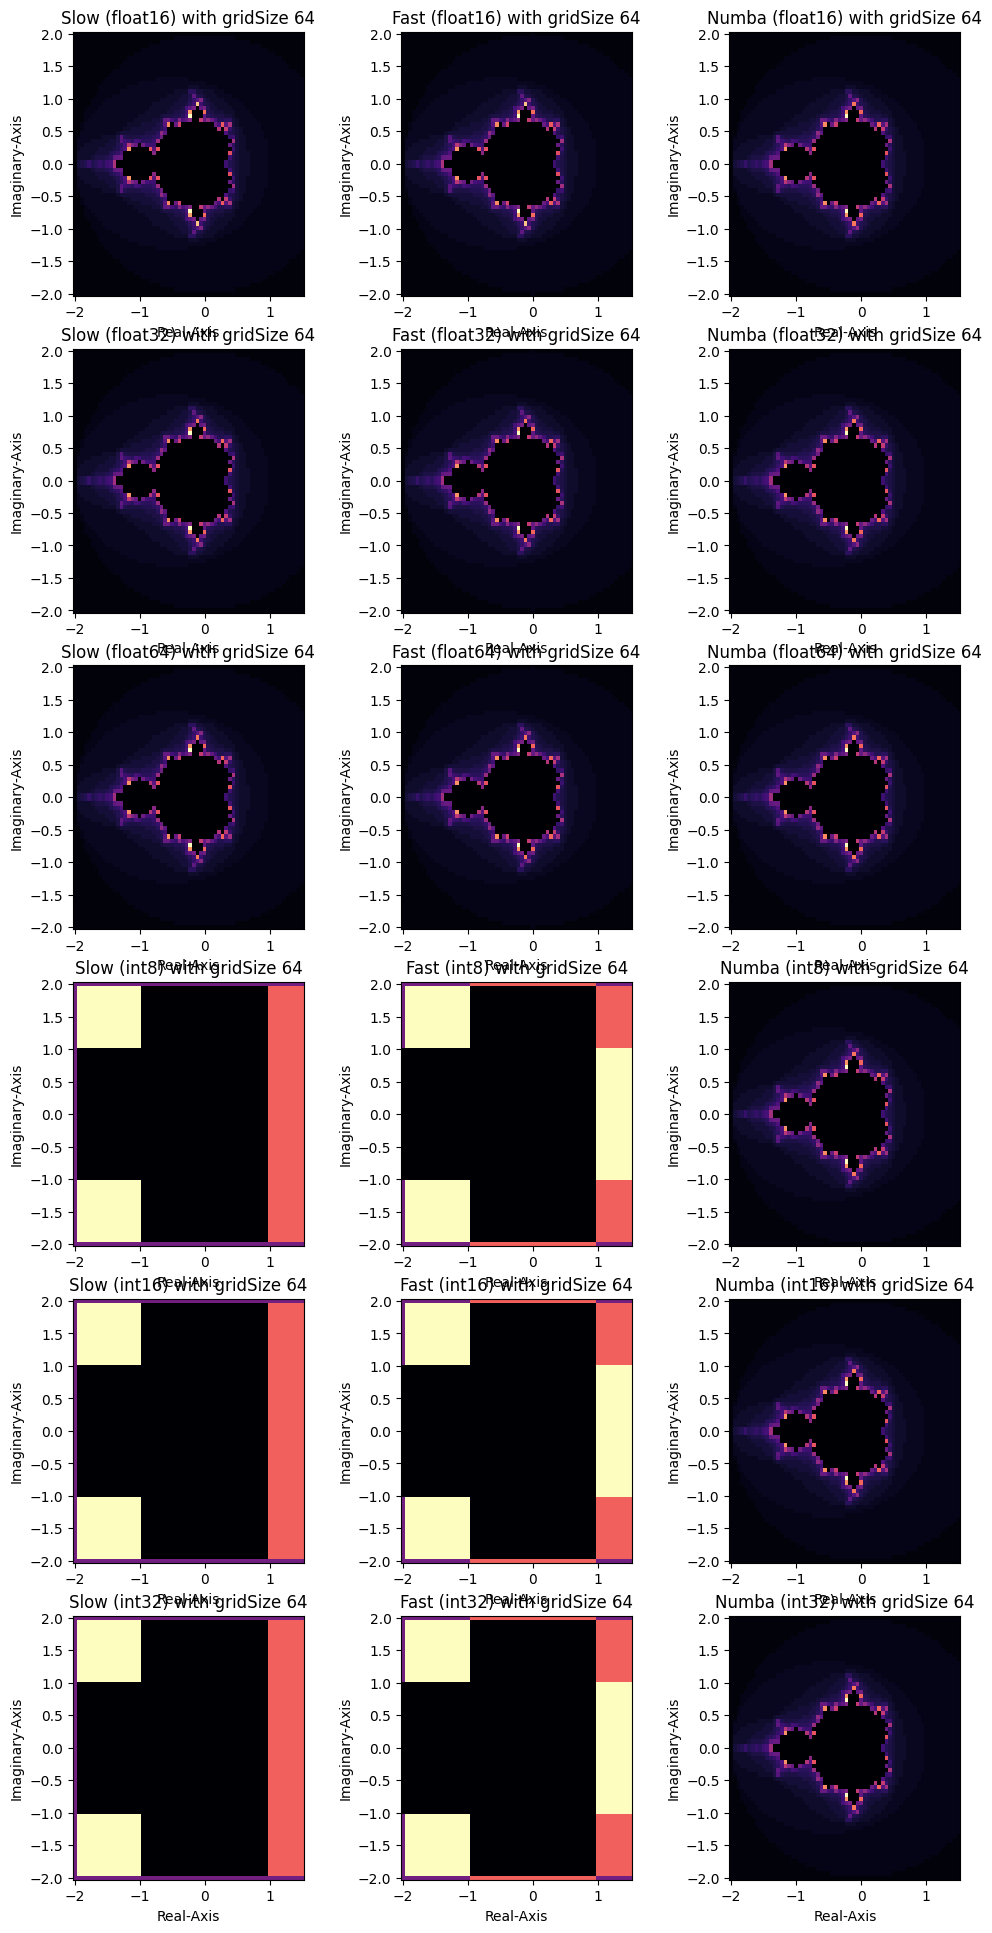

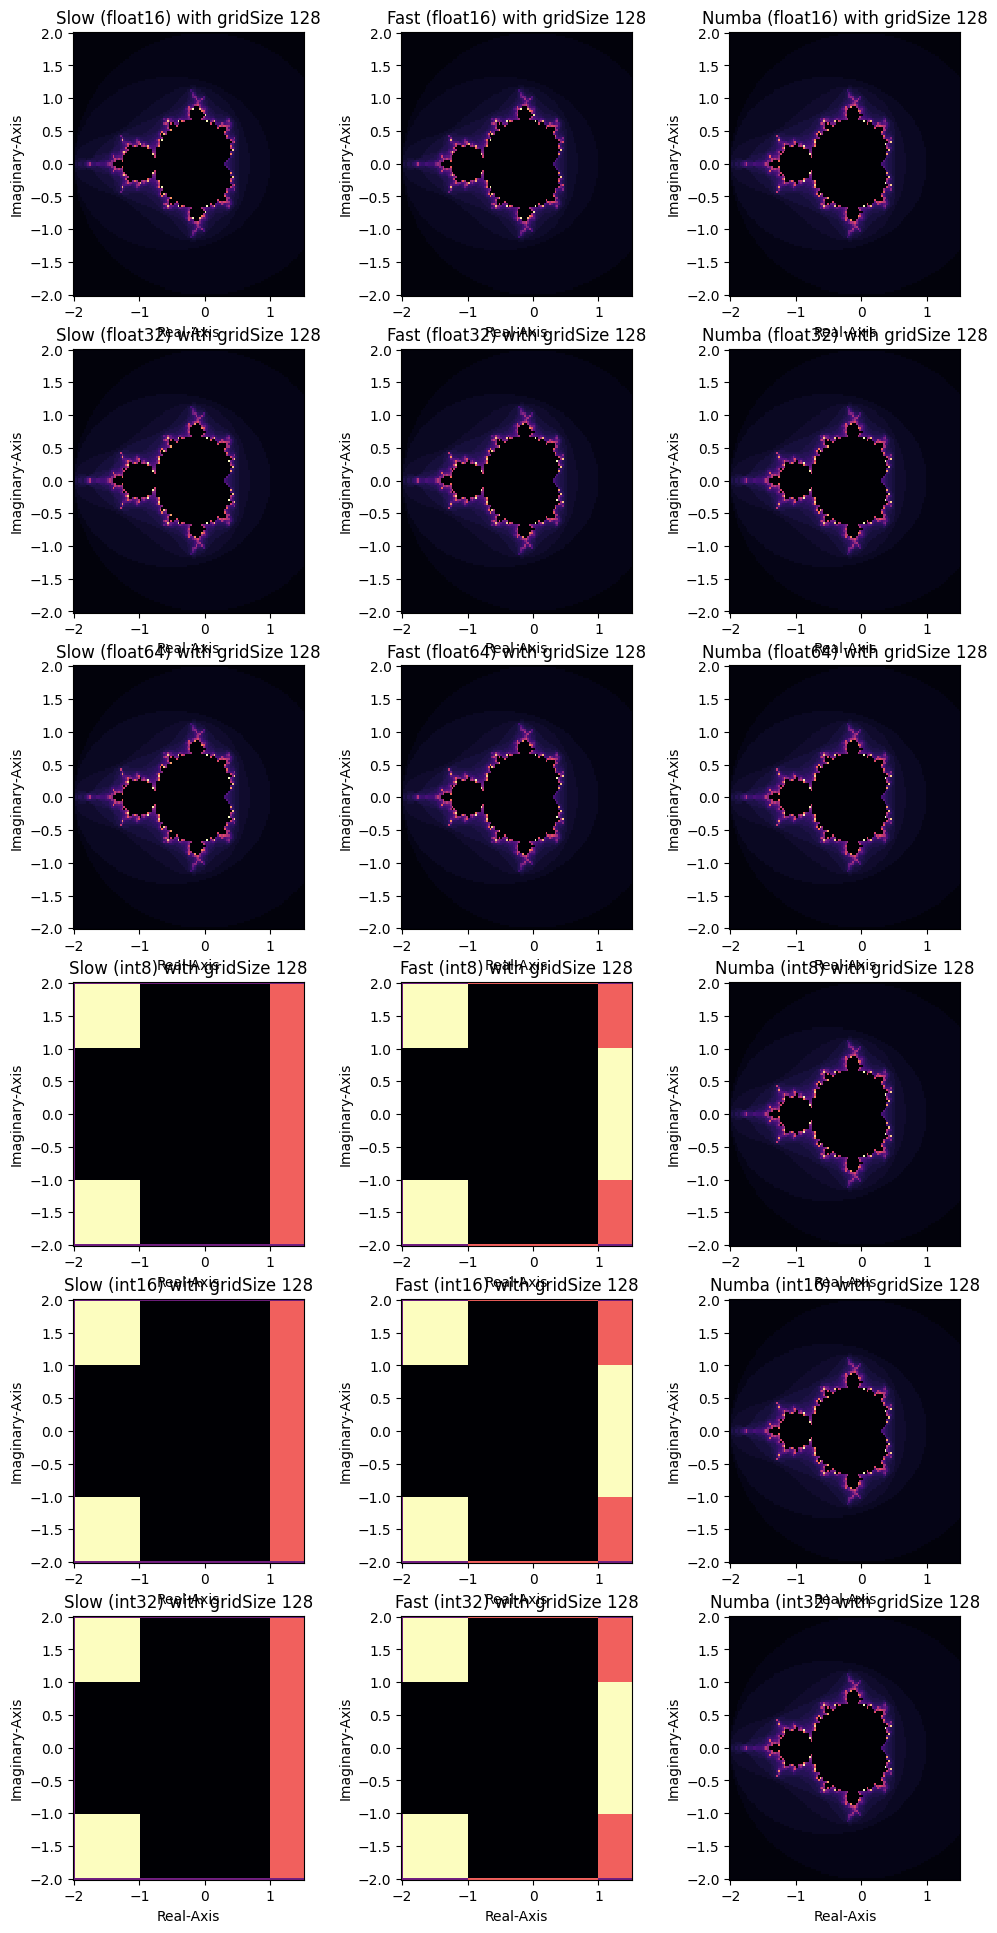

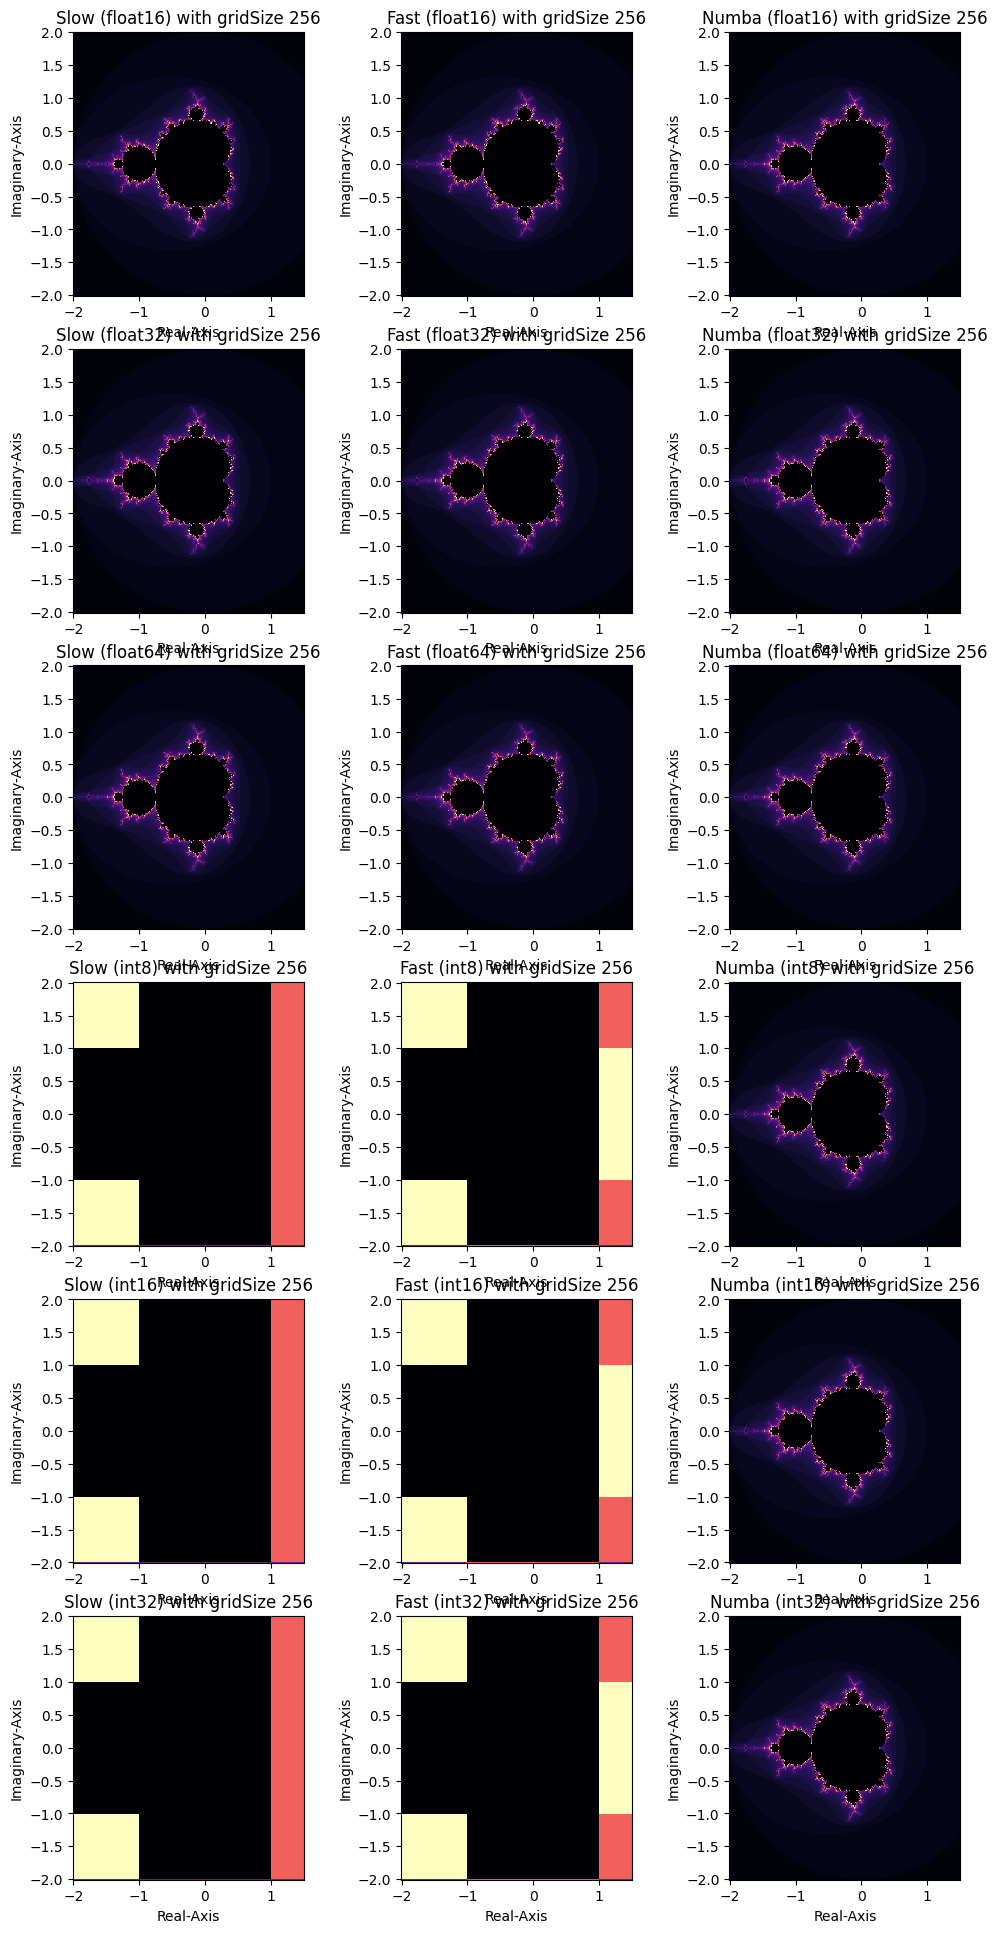

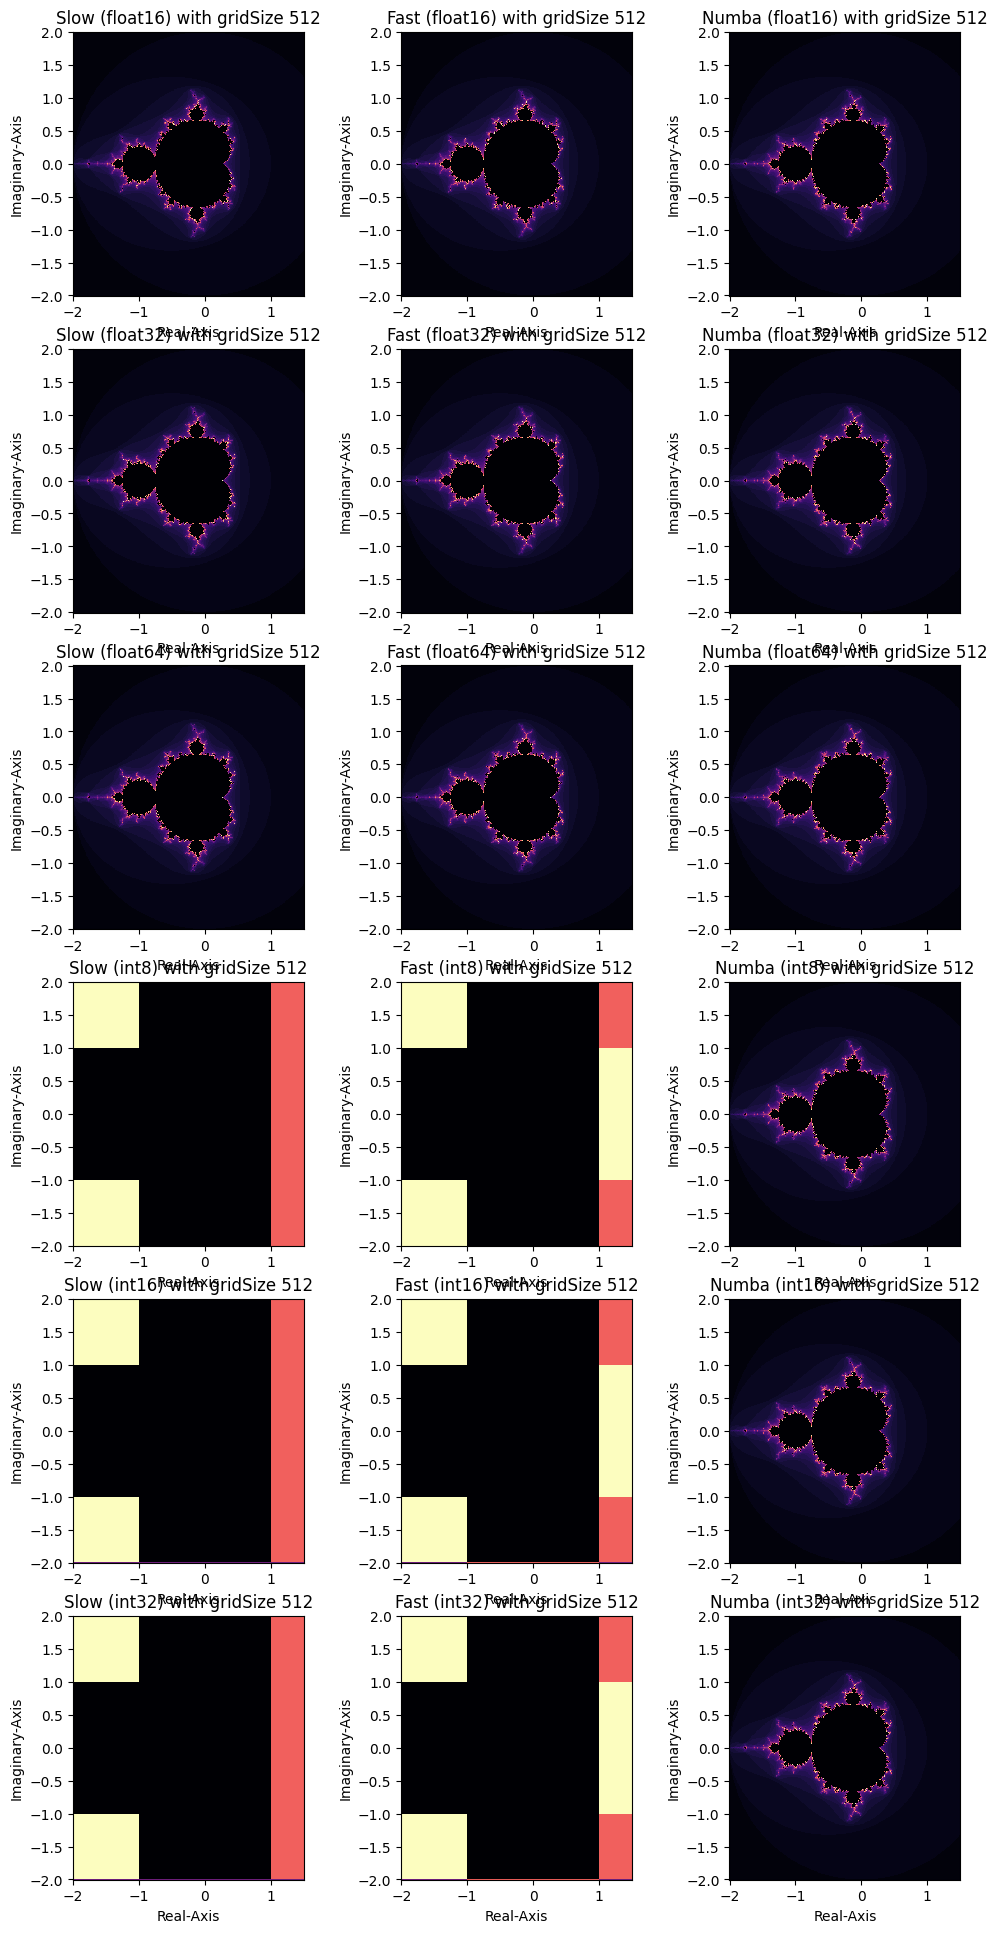

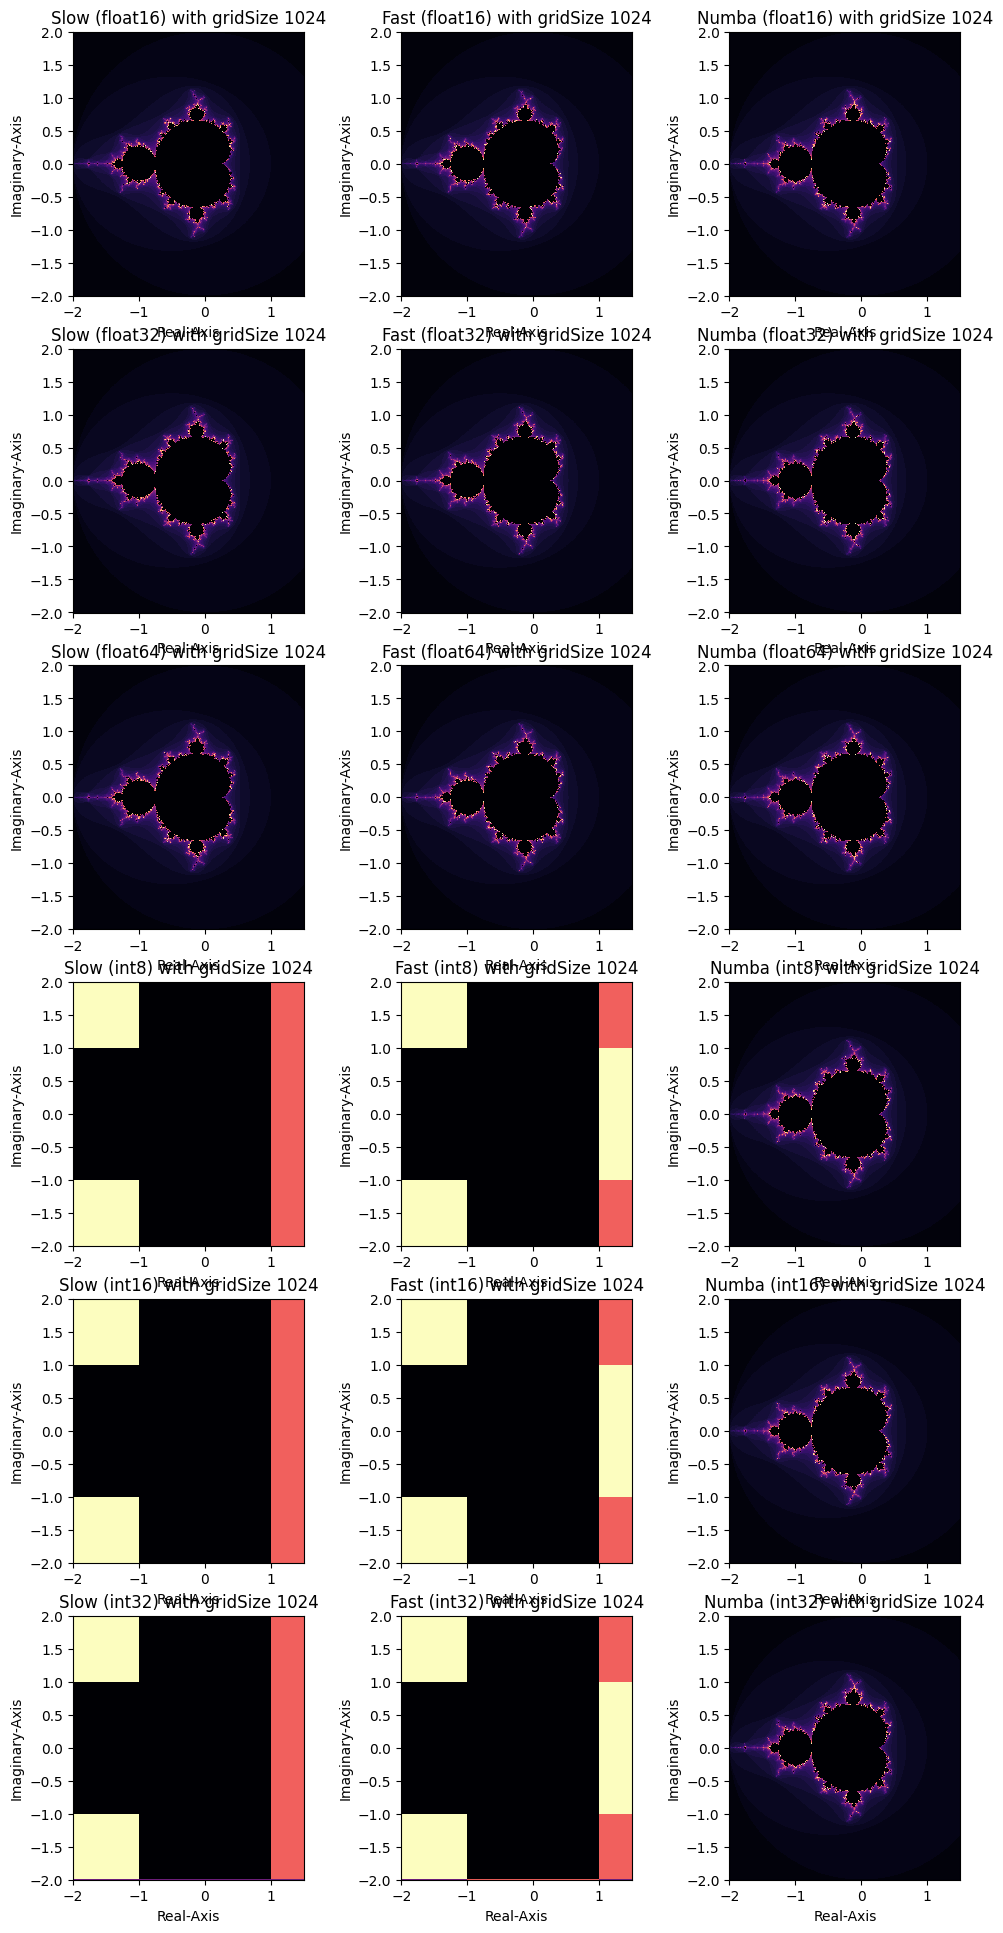

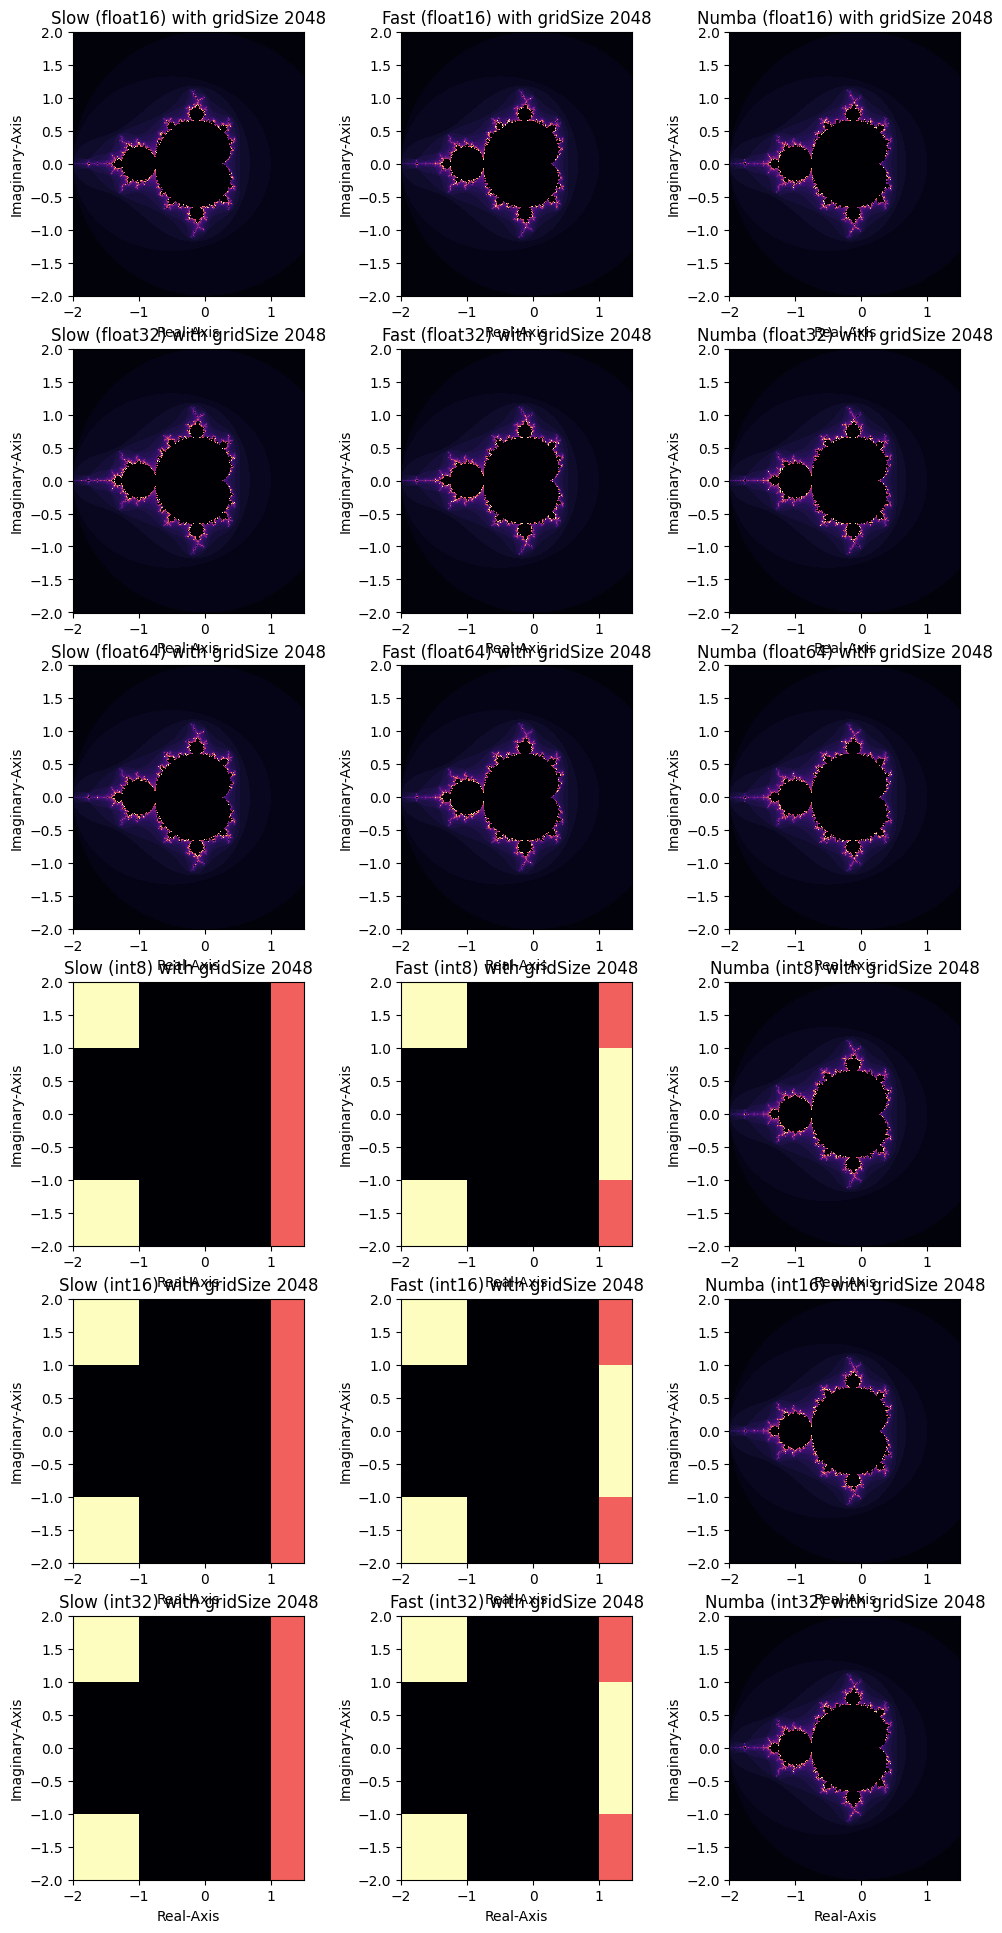

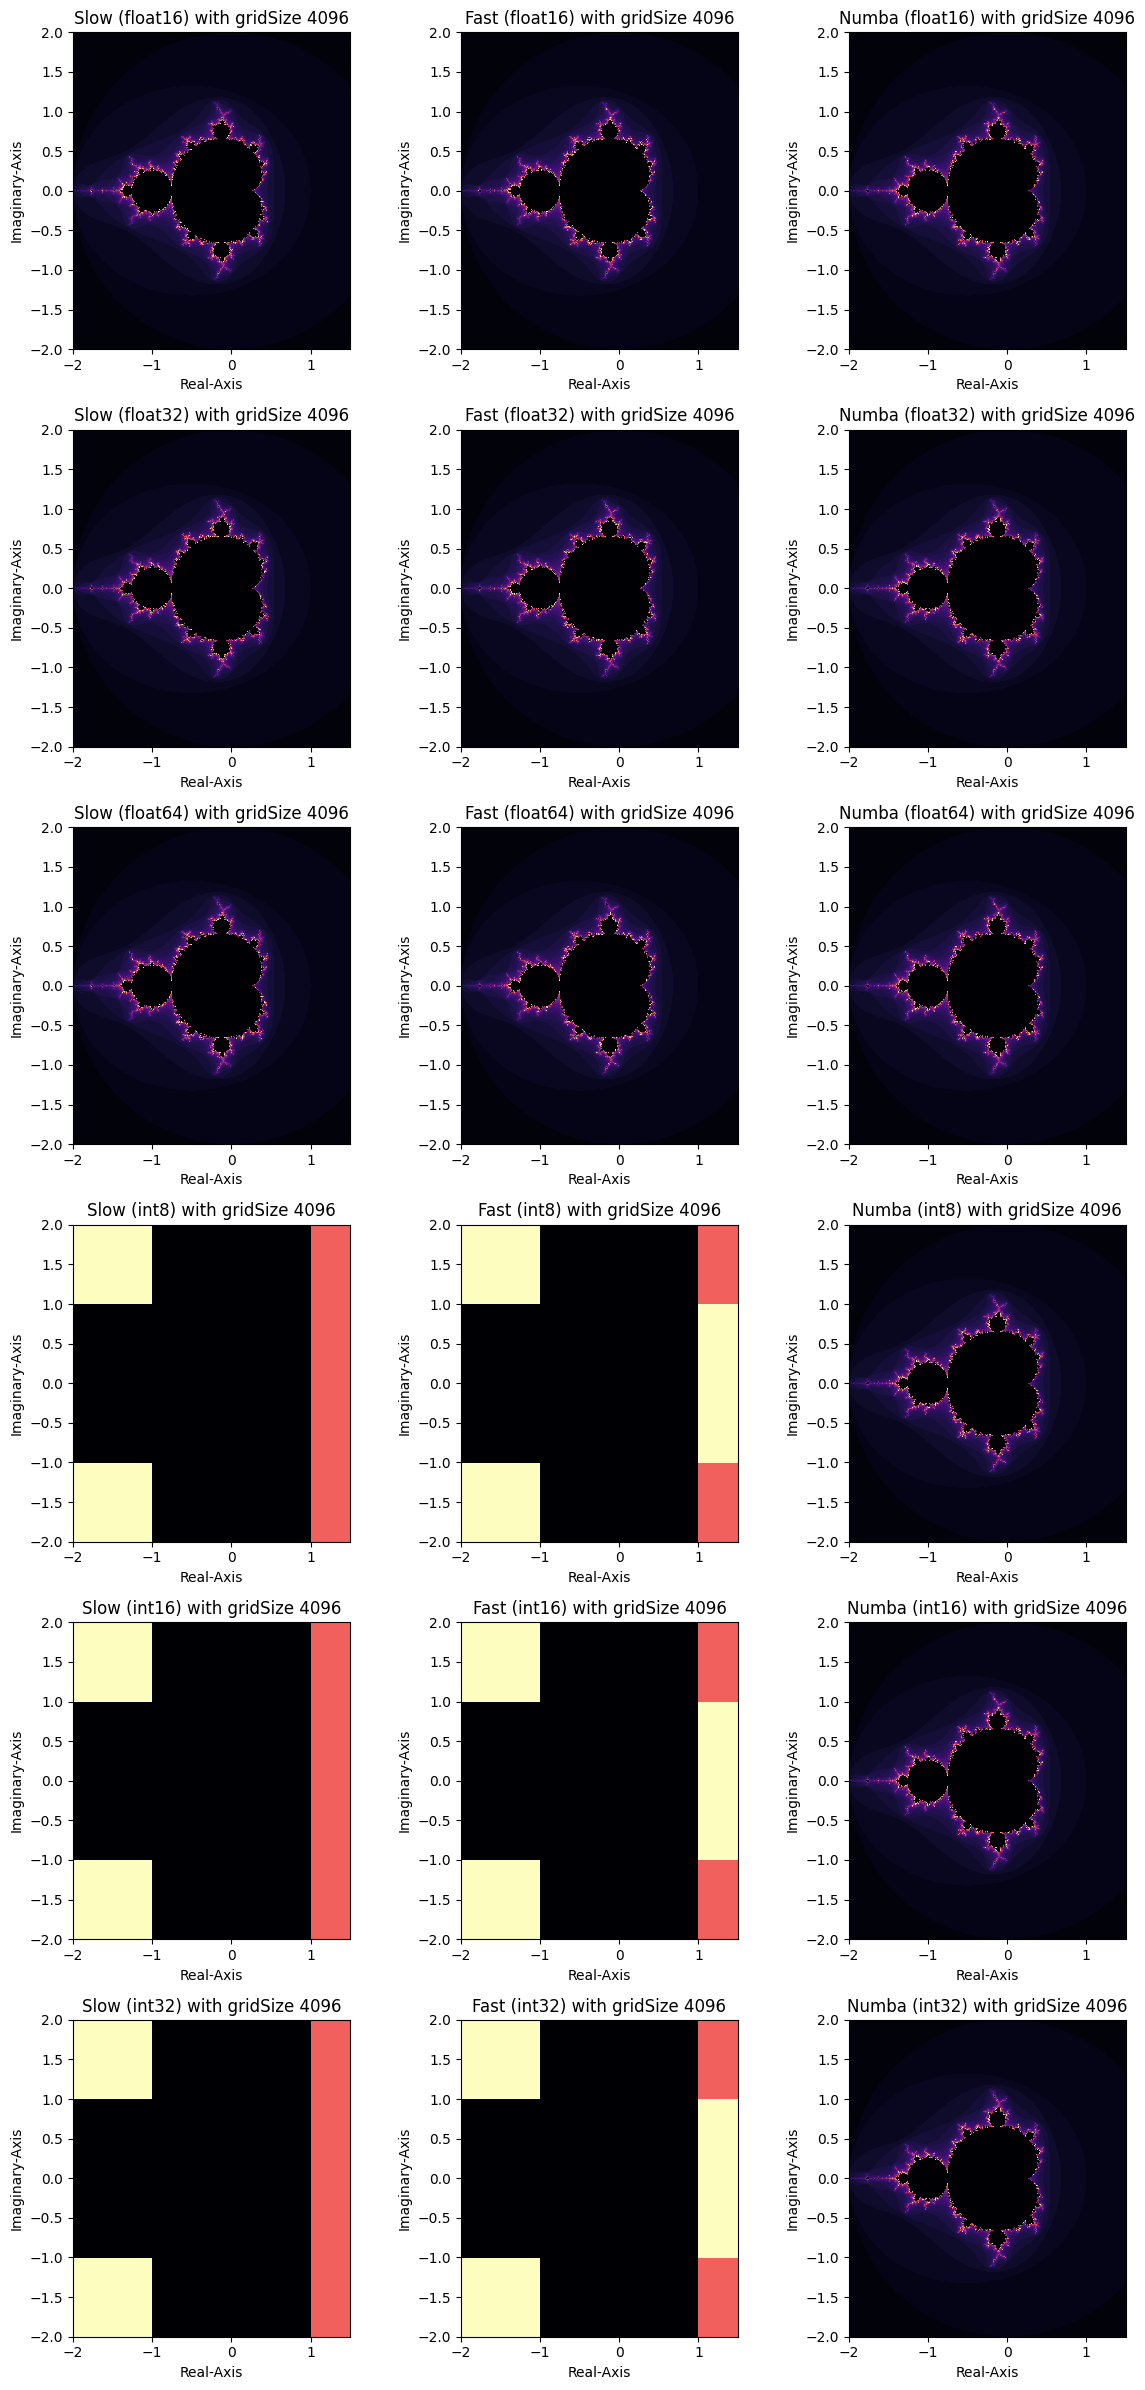

In [ ]:
print("Program begun")
resultsForSummary = []

if sizeComparison:
    for i in range(len(gridSizes)):
        gridSize = gridSizes[i]
        print(f"\n\n\nUsing gridsize {gridSize}")
        results = dataTypeComparison(gridSize)
        resultsForSummary.extend(results)
        if regionTest:
            regionComparison(gridSize)
else: 
    gridSize = 512 # for speed in testing
    print(f"\n\n\nUsing gridsize {gridSize}")
    results = dataTypeComparison(gridSize)
    resultsForSummary.extend(results)
    if regionTest:
        regionComparison(gridSize)


if cProfiling: 
    print("cProfile testing initiated:")
    cProfile.run("mandelBrot(-2,1.5,-2,2,gridSize,np.float64)",'naiveProfile.prof')
    cProfile.run("mandelBrotFast(-2,1.5,-2,2,gridSize,np.float64)",'fastProfile.prof')
    for name in ('naiveProfile.prof', 'fastProfile.prof'):
        stats = pstats.Stats(name)
        stats.sort_stats('cumulative')
        stats.print_stats(10)
else:
    print("cProfiling has not been done this run")

if testMemory:
    memoryLayoutTest()
    print("\n")
    #memoryProfileComparison()
else:
    print("Memory testing has not been done this run")

if makePlots:
    if gridPlot:
        plt.tight_layout()
    plt.show()
    
print("\n")
# Do note that it has taken my laptop 456 minutes (a little over 7.5 hours) to run this with integers as well

Note that the integer versions of mandelbrot are disastrous, and the plots are not interpretable for the naive and numpy versions, but are still interpretable in the numba version, as numba converts everything to floats, and therefore overrule the integer datatype. 

nevertheless, comparison between iterationtime between ints and floats is somewhat interesting

The results can be summarized to:

In [8]:
summarize(resultsForSummary)

In summary:
  Grid |    DType |     Slow |     Fast |    Numba |  NumbaParallel |    S/F |    S/N |    F/N |   S/NP |   F/NP |   N/NP
-------------------------------------------------------------------------------------------------------------------------
    64 | float16  |   0.0149 |   0.0017 |   0.0001 |         0.0002 |   8.85 | 125.72 |  14.21 |  98.06 |  11.08 |   0.78
    64 | float32  |   0.0160 |   0.0018 |   0.0001 |         0.0001 |   9.00 | 134.63 |  14.96 | 128.25 |  14.25 |   0.95
    64 | float64  |   0.0214 |   0.0024 |   0.0002 |         0.0001 |   9.03 | 102.18 |  11.31 | 145.49 |  16.11 |   1.42
    64 | int8     |   0.0726 |   0.0023 |   0.0001 |         0.0001 |  31.43 | 520.02 |  16.55 | 499.27 |  15.89 |   0.96
    64 | int16    |   0.0571 |   0.0021 |   0.0001 |         0.0001 |  26.93 | 493.71 |  18.33 | 404.66 |  15.03 |   0.82
    64 | int32    |   0.0616 |   0.0022 |   0.0001 |         0.0001 |  27.80 | 468.82 |  16.87 | 503.88 |  18.13 |   1.07
   128 | flo